# Agricultural Land Area (percentage of total land area)
In this notebook we will predict Agricultural Land Area of a country based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure
- Cleaning and assessing Agricultural Land data 

- Combining Agricultural Land data with Predictor data
- Exploring correlations within the predictor data 
- Splitting the combined dataset in training, validation and testing data
    - With our outcome variable (Agricultural Land) lagged by 5 years
- Fitting baseline model (mean model)
- Fitting simple mixed effects model (time, population)
- Fitting simple mixed effects models with each predictor seperately (time, population, predictor_xyzab)
- Fitting theory driven mixed effects model of social (time, population, predictor_x, predictor_y, predictor_z)
- Fitting theory driven mixed effects model of governance (time, population, predictor_x, predictor_y, predictor_z)
- Fitting a mixed effects decision tree model, random forest with all predictors
- Compare model predictions 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [2]:
#Read file 
df = pd.read_csv('Data/agricultural_land_percent.csv', skiprows=4)



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            0 non-null      float64
 5   1961            227 non-null    float64
 6   1962            227 non-null    float64
 7   1963            227 non-null    float64
 8   1964            227 non-null    float64
 9   1965            227 non-null    float64
 10  1966            227 non-null    float64
 11  1967            227 non-null    float64
 12  1968            227 non-null    float64
 13  1969            227 non-null    float64
 14  1970            227 non-null    float64
 15  1971            227 non-null    float64
 16  1972            227 non-null    float64
 17  1973            227 non-null    flo

In [4]:
df.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
count,0.0,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,...,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,0.0,0.0,0.0
mean,NaN,35.676307,35.714121,35.862026,35.958325,36.033822,36.127180,36.160458,36.233955,36.285051,...,37.252775,37.266105,37.325276,37.279831,37.282645,37.257021,37.252197,NaN,NaN,NaN
std,NaN,21.072501,21.055841,21.022617,20.971464,20.894872,20.875353,20.857316,20.864413,20.871513,...,20.384501,20.442106,20.446815,20.469668,20.454550,20.457884,20.477959,NaN,NaN,NaN
min,NaN,0.262821,0.269231,0.262821,0.294872,0.301282,0.282051,0.275641,0.275641,0.301282,...,0.557692,0.557692,0.538462,0.538462,0.538462,0.512821,0.500000,NaN,NaN,NaN
25%,NaN,19.360001,19.381317,19.382282,19.389962,19.584393,19.586731,19.625135,19.753356,19.731642,...,21.473644,21.521986,21.515013,21.383781,21.365196,21.387842,20.857157,NaN,NaN,NaN
50%,NaN,35.263368,35.328628,35.698420,35.810897,35.853779,35.876644,35.959177,36.263736,36.277372,...,38.515685,38.515685,38.524354,38.528483,38.526523,38.525914,38.513165,NaN,NaN,NaN
75%,NaN,50.469385,50.409109,50.467061,50.504798,50.484027,50.806931,50.916994,50.916994,50.995610,...,48.609373,48.624911,48.639407,48.653902,48.770066,48.799058,48.790910,NaN,NaN,NaN
max,NaN,93.440750,92.840818,92.223746,91.898069,91.263856,90.932465,90.913453,90.913453,90.893420,...,82.662553,81.506685,81.272801,81.081019,80.763475,80.841121,81.892523,NaN,NaN,NaN


In [5]:
summary = df.describe()

# Get the row corresponding to the count statistic
count_row = summary.loc['count']

# Filter for columns where the count is 0.0
columns_with_zero_count = count_row[count_row == 0.0].index.tolist()

print(columns_with_zero_count)

['1960', '2022', '2023', 'Unnamed: 68']


In [6]:
#Removing zero count columns from data
df_full = df.drop(columns=columns_with_zero_count)

print(df_full)

                    Country Name Country Code  \
0                          Aruba          ABW   
1    Africa Eastern and Southern          AFE   
2                    Afghanistan          AFG   
3     Africa Western and Central          AFW   
4                         Angola          AGO   
..                           ...          ...   
261                       Kosovo          XKX   
262                  Yemen, Rep.          YEM   
263                 South Africa          ZAF   
264                       Zambia          ZMB   
265                     Zimbabwe          ZWE   

                         Indicator Name  Indicator Code       1961       1962  \
0    Agricultural land (% of land area)  AG.LND.AGRI.ZS  11.111111  11.111111   
1    Agricultural land (% of land area)  AG.LND.AGRI.ZS  42.345489  42.328470   
2    Agricultural land (% of land area)  AG.LND.AGRI.ZS  57.878356  57.955016   
3    Agricultural land (% of land area)  AG.LND.AGRI.ZS  32.890182  32.941914   
4    A

In [7]:
#Removing non countries 

ISO_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']


df_iso = df_full[df_full['Country Code'].isin(ISO_list)]

print(df_iso)

     Country Name Country Code                      Indicator Name  \
0           Aruba          ABW  Agricultural land (% of land area)   
2     Afghanistan          AFG  Agricultural land (% of land area)   
4          Angola          AGO  Agricultural land (% of land area)   
5         Albania          ALB  Agricultural land (% of land area)   
6         Andorra          AND  Agricultural land (% of land area)   
..            ...          ...                                 ...   
260         Samoa          WSM  Agricultural land (% of land area)   
262   Yemen, Rep.          YEM  Agricultural land (% of land area)   
263  South Africa          ZAF  Agricultural land (% of land area)   
264        Zambia          ZMB  Agricultural land (% of land area)   
265      Zimbabwe          ZWE  Agricultural land (% of land area)   

     Indicator Code       1961       1962       1963       1964       1965  \
0    AG.LND.AGRI.ZS  11.111111  11.111111  11.111111  11.111111  11.111111   
2  

In [9]:
#Making df long
melted_df = pd.melt(df_iso, id_vars=['Country Code', 'Country Name', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='agricultural_land')

print(melted_df)

      Country Code  Country Name                      Indicator Name  \
0              ABW         Aruba  Agricultural land (% of land area)   
1              AFG   Afghanistan  Agricultural land (% of land area)   
2              AGO        Angola  Agricultural land (% of land area)   
3              ALB       Albania  Agricultural land (% of land area)   
4              AND       Andorra  Agricultural land (% of land area)   
...            ...           ...                                 ...   
13110          WSM         Samoa  Agricultural land (% of land area)   
13111          YEM   Yemen, Rep.  Agricultural land (% of land area)   
13112          ZAF  South Africa  Agricultural land (% of land area)   
13113          ZMB        Zambia  Agricultural land (% of land area)   
13114          ZWE      Zimbabwe  Agricultural land (% of land area)   

       Indicator Code  Year  agricultural_land  
0      AG.LND.AGRI.ZS  1961          11.111111  
1      AG.LND.AGRI.ZS  1961          

In [10]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13115 entries, 0 to 13114
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Code       13115 non-null  object 
 1   Country Name       13115 non-null  object 
 2   Indicator Name     13115 non-null  object 
 3   Indicator Code     13115 non-null  object 
 4   Year               13115 non-null  object 
 5   agricultural_land  11725 non-null  float64
dtypes: float64(1), object(5)
memory usage: 614.9+ KB


In [11]:
melted_df['Year'] = melted_df['Year'].astype(float)

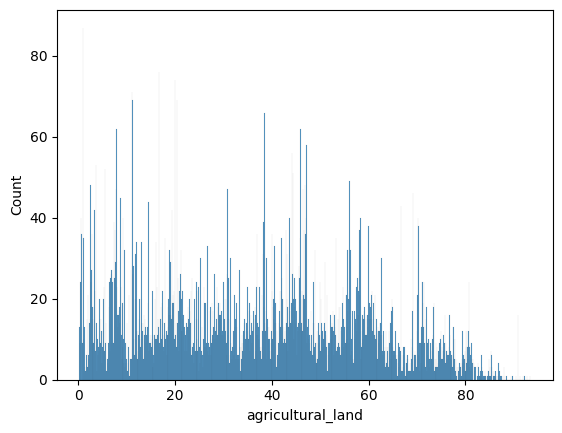

In [12]:
sns.histplot(data=melted_df, x='agricultural_land', binwidth=0.1)
plt.show()

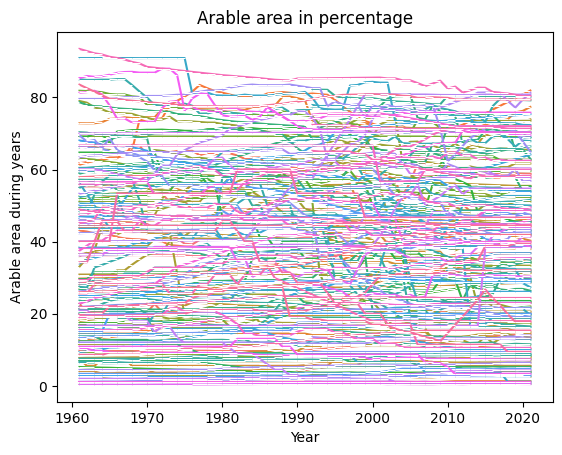

In [14]:
sns.lineplot(data=melted_df, x='Year', y='agricultural_land', hue='Country Name', marker=False, legend=False)

# Add title and labels
plt.title('Arable area in percentage')
plt.xlabel('Year')
plt.ylabel('Arable area during years')


# Show the plot
plt.show()